In [11]:
%pylab inline

import scipy.stats as stat
import sklearn.linear_model as lm
import scipy.optimize as opt
import pandas as pd
from scipy.ndimage.interpolation import shift

rcParams['figure.figsize'] = (12,8)
rcParams['axes.grid'] = True

Populating the interactive namespace from numpy and matplotlib


In [4]:
# This notebook aims to study the empirical distribution of a stock or stock index daily returns
# with the goal of identifying how "non-normal" such a distribution is and pricing a one-day skew of sorts.

In [5]:
# Pull 19 years of SPX daily prices
import pandas_datareader.data as web
df = web.DataReader('^GSPC', 'yahoo', '2000-11-25', '2019-11-25').Close
#df = web.DataReader('SPY', 'stooq').Close.iloc[::-1]

In [6]:
# Compute log returns, shifted log returns with zero mean, and the realized vol over the series
LnR = np.log(df/df.shift(1))
LnR_normed = (LnR - LnR.mean()).iloc[1:]
vol = np.sqrt((LnR_normed**2).mean())

In [7]:
# Builds a cumulative distribution function off empirical data
def build_cdf(X,n=500):
    cdfx = np.linspace(X.min(),X.max(),n)
    f_cdf = np.vectorize(lambda x: len(X[X < x])/len(X))
    cdf_inv = np.vectorize(lambda p: cdfx[len(cdfy[cdfy<=p])-1])
    return f_cdf,cdfx,f_cdf(cdfx),cdf_inv

In [9]:
# Get the actual CDF and inverse CDF from our data
f_cdf,cdfx,cdfy,cdf_inv = build_cdf(LnR_normed,n=200)
# Compute the normal CDF using the vol over the whole series
norm_equiv = stat.norm.cdf(cdfx,loc=0,scale=vol)

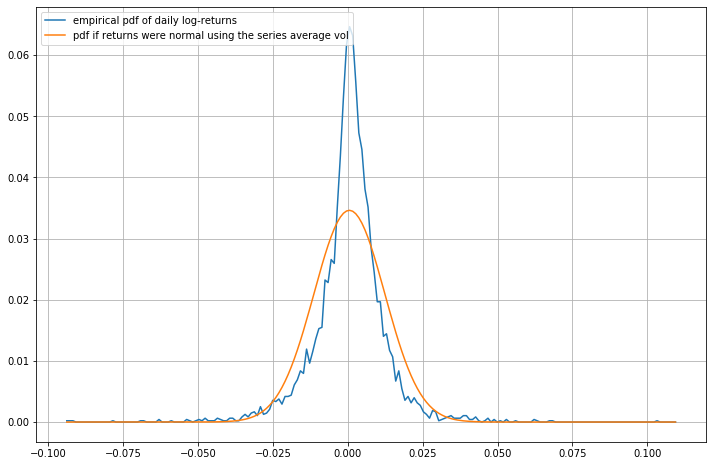

In [12]:
plot(cdfx[1:],np.diff(cdfy),label='empirical pdf of daily log-returns')
plot(cdfx[1:],np.diff(norm_equiv), label='pdf if returns were normal using the series average vol')
legend(loc='upper left')

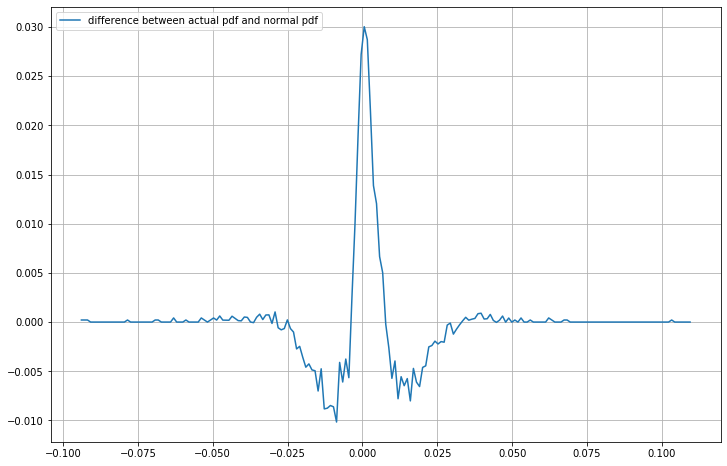

In [13]:
plot(cdfx[1:],np.diff(cdfy)-np.diff(norm_equiv),label='difference between actual pdf and normal pdf')
legend(loc='upper left')

In [14]:
# Solve for the vol of a normal distribution such that the cdf matches the empirical data. 
# I.e. moves of -5% or lower occur with frequency as if the returns were normal on a X vol
solver = np.vectorize(lambda i: opt.brentq(lambda v: cdfy[i]-stat.norm.cdf(cdfx[i],scale=v),0.00001,1000.0))
solved_vols = solver(np.arange(len(cdfy)))

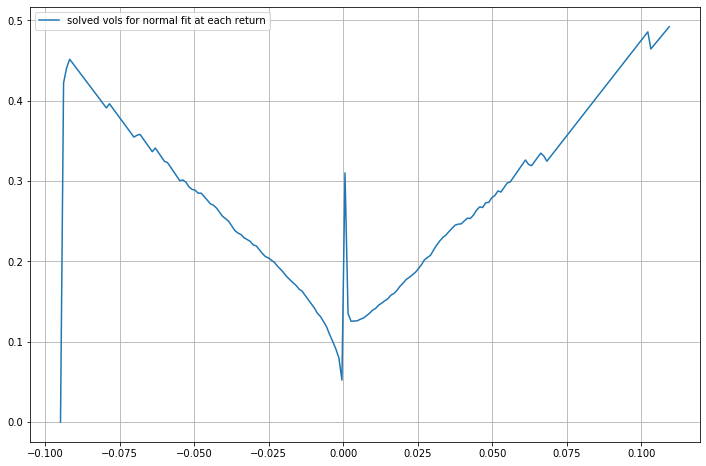

In [16]:
plot(cdfx,solved_vols*np.sqrt(252), label='solved vols for normal fit at each return')
legend(loc='upper left')

In [17]:
# Generate a hypothetical path using the empirical distribution
def CDFgen(num_paths,num_steps):
    rands = np.random.uniform(size=(num_paths,num_steps))
    return np.exp(cdf_inv(rands).cumsum(axis=1))

In [18]:
paths = CDFgen(100000,252)

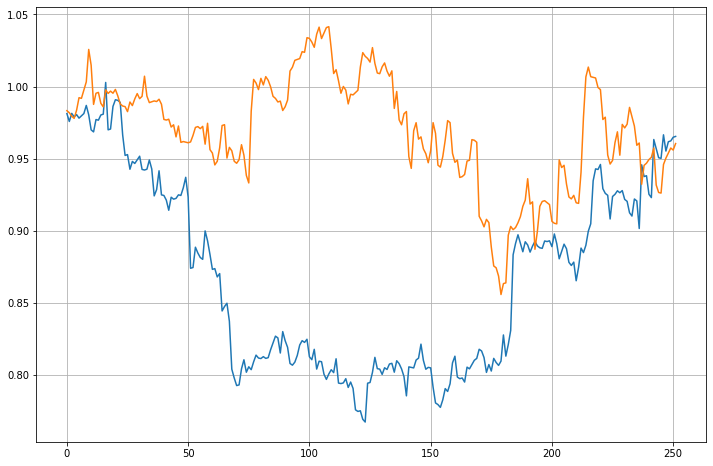

In [24]:
# Example paths
plot(paths[0])
plot(paths[1])

In [19]:
# What is the realized vol of the simulation?
sim_vol = np.sqrt((np.log(paths[:,1:]/paths[:,:-1])**2).mean())
sim_vol*np.sqrt(252)

0.18794232394122753

In [20]:
def GBM(sigma,num_paths,num_steps):
    return (1+sigma*np.random.normal(size=(num_paths,num_steps))).cumprod(axis=1)

In [21]:
# Generate a path assuming GBM with the same vol as the empirical-generated paths 
gbmpaths = GBM(sim_vol,100000,252)